<a href="https://colab.research.google.com/github/Laura-Tovo/Ubiquity/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Hypothesis 1: More cars = worse air quality

Loading data

In [52]:
# Traffic data (Jan-)
path_traffic = 'scats_detector_volume_jan-jun-2020.csv'

traffic = pd.read_csv(path_traffic)

# Detailed air quality data (April 2022)
path_air = 'AirView_DublinCity_Measurements_ugm3.csv'
air = pd.read_csv(path_air)

The air quality dataset contains high-resolution measurements (1 second intervals)
from April 2022. The traffic dataset is from November 2019.
Therefore, the datasets DO NOT overlap in time.
This analysis remains exploratory only. It does not support causal conclusions,
but can help investigate general spatial or trend relationships.

Cleaning and preparing traffic data

Processing the air quality data

Attempt to match by date (note: different years)
-----------------------------
We perform a merge only to illustrate potential correlation visually
but dates do not actually match — this is a methodological limitation.

Exploratory analysis

In [53]:
# Weekly vehicle volume from SCATS dataset (Jan–Jun 2020)

# Build full date from Year, Month, Day
traffic['Date'] = pd.to_datetime(traffic[['Year', 'Month', 'Day']])

# Filter only the first 6 months (if needed)
traffic = traffic[(traffic['Date'] >= '2020-01-01') & (traffic['Date'] <= '2020-06-30')]

# Remove invalid counts
traffic = traffic.dropna(subset=['SumOfSumVolume'])
traffic['SumOfSumVolume'] = pd.to_numeric(traffic['SumOfSumVolume'], errors='coerce')

# Sum all volumes per day (across all sites)
traffic_daily = traffic.groupby('Date')['SumOfSumVolume'].sum().reset_index()
traffic_daily.rename(columns={'SumOfSumVolume': 'TotalVehicles'}, inplace=True)

# Add week number (ISO calendar) for grouping
traffic_daily['Week'] = traffic_daily['Date'].dt.isocalendar().week

# Aggregate weekly total (or mean) vehicle volume
traffic_weekly = (
    traffic_daily.groupby('Week')['TotalVehicles']
    .mean()  # or .sum() if you want total volume per week instead of average per day
    .reset_index()
)

# Preview weekly traffic
#traffic_weekly

In [54]:
# Load full air quality dataset
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
cols = ['gps_timestamp'] + pollutants

air_2 = pd.read_csv(path_air, usecols=cols, parse_dates=['gps_timestamp'], low_memory=False)

# Filter for April to September 2022
#air_2 = air_2[(air_2['gps_timestamp'] >= '2022-04-01') & (air['gps_timestamp'] <= '2022-09-30')]

# Remove negative values
for col in pollutants:
   air_2 = air_2[air_2[col] >= 0]

# Create week number
air_2['Week'] = air_2['gps_timestamp'].dt.isocalendar().week

# Aggregate weekly averages for each pollutant
air_weekly = air_2.groupby('Week')[pollutants].mean().reset_index()


In [55]:
air_2.head(5)

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week
5,2022-04-07 14:56:41+00:00,23.953,14.734,60.885,0.274,763.271,7.266,14
8,2022-04-07 14:56:44+00:00,32.170,6.175,62.216,0.299,763.271,3.757,14
22,2022-04-07 14:56:58+00:00,33.591,3.622,64.880,0.302,788.260,7.781,14
27,2022-04-07 14:57:03+00:00,3.791,2.744,61.771,0.295,811.146,7.031,14
44,2022-04-07 14:57:20+00:00,57.616,17.058,55.778,0.306,783.987,7.936,14


# Database time stamp

For better understanding of the timebases we devided the analysis throughout the day, weeks and month, but for the better comparison to the Traffic database we compared them throughout the weeks

In [56]:
def calculateMean(data, columns):
    meanData = []
    for col in columns:
        meanData.append(data[col].mean())
    return meanData

In [57]:

def plotGraph_(meanData, labels, title, ylabel):
    plt.figure(figsize=(8,5))
    plt.plot(labels, meanData, marker='o')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [58]:
air_2.head(5) # The air database is updated every few seconds, so for a better analysis we devide that

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week
5,2022-04-07 14:56:41+00:00,23.953,14.734,60.885,0.274,763.271,7.266,14
8,2022-04-07 14:56:44+00:00,32.170,6.175,62.216,0.299,763.271,3.757,14
22,2022-04-07 14:56:58+00:00,33.591,3.622,64.880,0.302,788.260,7.781,14
27,2022-04-07 14:57:03+00:00,3.791,2.744,61.771,0.295,811.146,7.031,14
44,2022-04-07 14:57:20+00:00,57.616,17.058,55.778,0.306,783.987,7.936,14


In [91]:
# created a copy to not mess up earlier database
air_ts = air_2.copy()
# adds column hour
air_ts['Hour'] = air_ts['gps_timestamp'].dt.hour
# extract date
air_ts['Day_date'] = air_ts['gps_timestamp'].dt.date
# sequency (1, 2, 3, ...)
air_ts['Day_number'] = (air_ts['Day_date'] != air_ts['Day_date'].shift()).cumsum()
# the time stamp starts on april 7th 2022, a Thursday
air_ts.head(2)

,gps_timestamp,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Week,Hour,Day_date,Day_number
5,2022-04-07 14:56:41+00:00,23.953,14.734,60.885,0.274,763.271,7.266,14,14,2022-04-07,1
8,2022-04-07 14:56:44+00:00,32.170,6.175,62.216,0.299,763.271,3.757,14,14,2022-04-07,1


In [86]:
air_ts['gps_timestamp'] = pd.to_datetime(air_ts['gps_timestamp'])

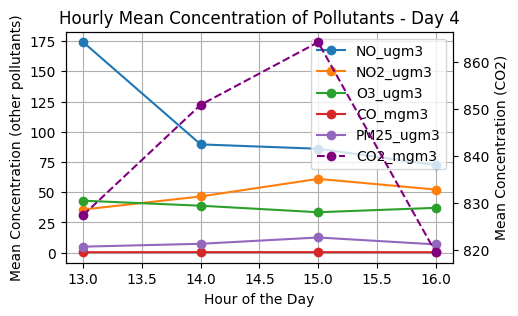

In [101]:
import matplotlib.pyplot as plt

def plot_pollutants_by_hour(air_ts, pollutants, day_number):
    # 1. Filtra para o day_number desejado
    df_filtered = air_ts[air_ts['Day_number'] == day_number]

    # 2. Agrupa por hora e calcula a média dos poluentes
    hourly_means = df_filtered.groupby('Hour')[pollutants].mean().reset_index()

    # 3. Separa CO2 dos outros poluentes
    main_pollutants = [p for p in pollutants if p != 'CO2_mgm3']

    # 4. Cria figura e eixos
    fig, ax1 = plt.subplots(figsize=(10/2, 6/2))

    # Plota os poluentes principais no eixo primário
    for pollutant in main_pollutants:
        ax1.plot(hourly_means['Hour'], hourly_means[pollutant], label=pollutant, marker='o')
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Mean Concentration (other pollutants)')
    ax1.grid(True)

    # Plota o CO2 no eixo secundário
    ax2 = ax1.twinx()
    ax2.plot(hourly_means['Hour'], hourly_means['CO2_mgm3'], label='CO2_mgm3', color='purple', marker='o', linestyle='--')
    ax2.set_ylabel('Mean Concentration (CO2)')

    # Combina as legendas dos dois eixos
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title(f'Hourly Mean Concentration of Pollutants - Day {day_number}')
    plt.show()

# Exemplo de uso:
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
plot_pollutants_by_hour(air_ts, pollutants, day_number=4)

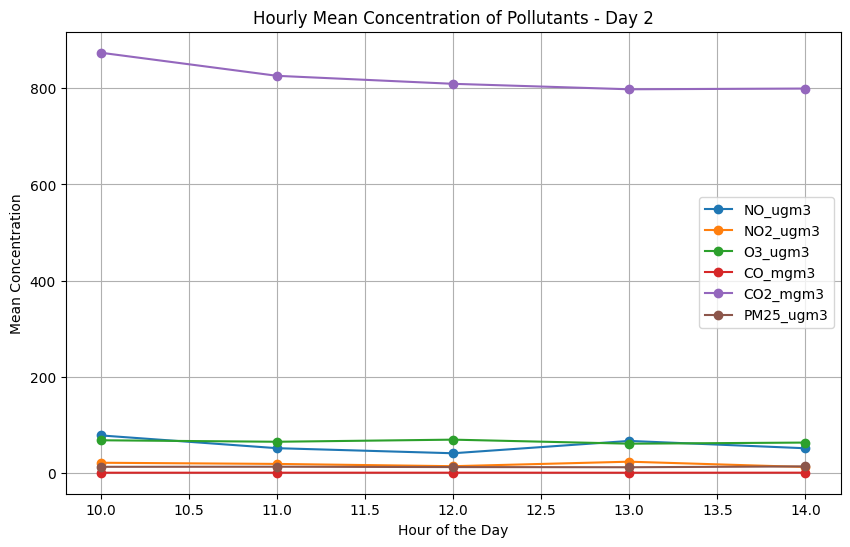

In [94]:
# We created a function that will help to analyse each day
import matplotlib.pyplot as plt

def plot_pollutants_by_hour(air_ts, pollutants, day_number):
    # 1. Filtra para o day_number desejado
    df_filtered = air_ts[air_ts['Day_number'] == day_number]

    # 2. Agrupa por hora e calcula a média dos poluentes
    hourly_means = df_filtered.groupby('Hour')[pollutants].mean().reset_index()

    # 3. Plota cada poluente
    plt.figure(figsize=(10,6))
    for pollutant in pollutants:
        plt.plot(hourly_means['Hour'], hourly_means[pollutant], label=pollutant, marker='o')

    plt.xlabel('Hour of the Day')
    plt.ylabel('Mean Concentration')
    plt.title(f'Hourly Mean Concentration of Pollutants - Day {day_number}')
    plt.legend()
    plt.grid(True)
    plt.xticks()  # Garante que todas as horas de 0 a 23 apareçam
    plt.show()

# Exemplo de uso:
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
plot_pollutants_by_hour(air_ts, pollutants, day_number=2)

In [78]:
# This section separates de Air quality database into Hour and Days to make an analysis time based
air_ts['gps_timestamp'] = pd.to_datetime(air_ts['gps_timestamp'])
# For the hourly analysis
air_hourly = air_ts.groupby('Hour')[pollutants].mean().reset_index()
air_daily = air_ts.groupby('Day_number')[pollutants].mean().reset_index()
air_hourly.head(5)

,Hour,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
0,6,108.245374,50.440332,8.666723,0.446228,902.726488,12.508163
1,7,123.677533,42.630533,20.456014,0.511380,891.707016,10.941771
2,8,101.728527,44.620333,36.459330,0.533885,885.147444,10.772069
3,9,84.023696,38.540053,36.413085,0.478014,856.363429,9.472398
4,10,72.451562,37.375154,36.593915,0.474986,848.367484,8.955861


In [70]:
air_hourly.info(), air_daily.info(), air_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hour        14 non-null     int32  
 1   NO_ugm3     14 non-null     float64
 2   NO2_ugm3    14 non-null     float64
 3   O3_ugm3     14 non-null     float64
 4   CO_mgm3     14 non-null     float64
 5   CO2_mgm3    14 non-null     float64
 6   PM25_ugm3   14 non-null     float64
 7   Week        14 non-null     Float64
 8   Day_number  14 non-null     float64
dtypes: Float64(1), float64(7), int32(1)
memory usage: 1.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Day_number  284 non-null    int64  
 1   NO_ugm3     284 non-null    float64
 2   NO2_ugm3    284 non-null    float64
 3   O3_ugm3     284 non-null    float64
 4   CO_mgm3     284 non-null    fl

(None, None, None)

In [32]:
air_weekly.iloc[:, 1:]

,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,Month
0,106.732688,40.848428,42.876551,0.329341,793.844304,6.954181,4.000000
1,96.063406,41.390429,42.927625,0.490162,847.548237,7.628012,4.000000
2,76.363429,36.352993,53.679598,0.446631,829.968011,12.017762,4.000000
3,65.681073,27.858734,53.506079,0.404328,810.763695,13.375077,4.000000
4,72.138663,32.071114,46.029941,0.406746,828.429339,6.546552,5.000000
5,72.903017,41.274903,55.549615,0.481453,865.932401,9.645686,5.000000
6,76.310439,41.396083,52.256620,0.441227,851.854373,6.399845,5.000000
7,114.216896,49.901770,48.361502,0.447319,870.725113,11.312701,5.000000
8,106.275091,71.153582,57.494351,0.528490,877.340260,14.694399,5.795778
9,69.898041,27.787403,33.729904,0.471563,844.580479,4.639270,6.000000


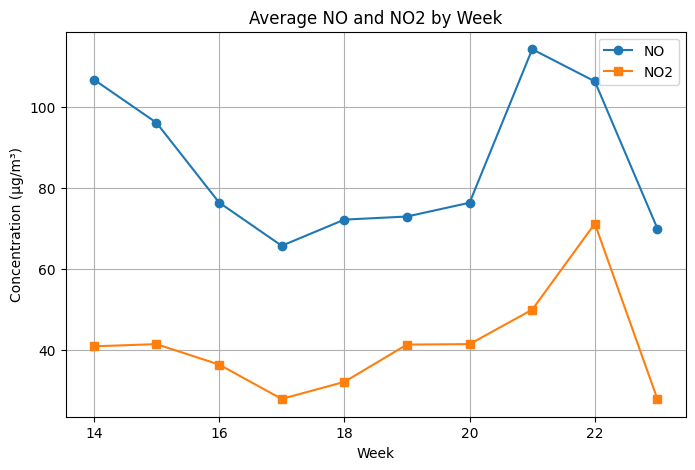

In [19]:
labels = air_weekly_['Week']

NO_data = air_weekly['NO_ugm3']
NO2_data = air_weekly['NO2_ugm3']

plt.figure(figsize=(8,5))
plt.plot(labels, NO_data, marker='o', label='NO')
plt.plot(labels, NO2_data, marker='s', label='NO2')
plt.title('Average NO and NO2 by Week')
plt.xlabel('Week')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Merge

In [ ]:
# Merge traffic and air quality weekly data
merged = pd.merge(traffic_weekly, air_weekly, on='Week')
# ⚠️ NOTE:
# These datasets refer to different years (2019 and 2022)
# and are only used for exploratory comparison of weekly patterns.
#merged

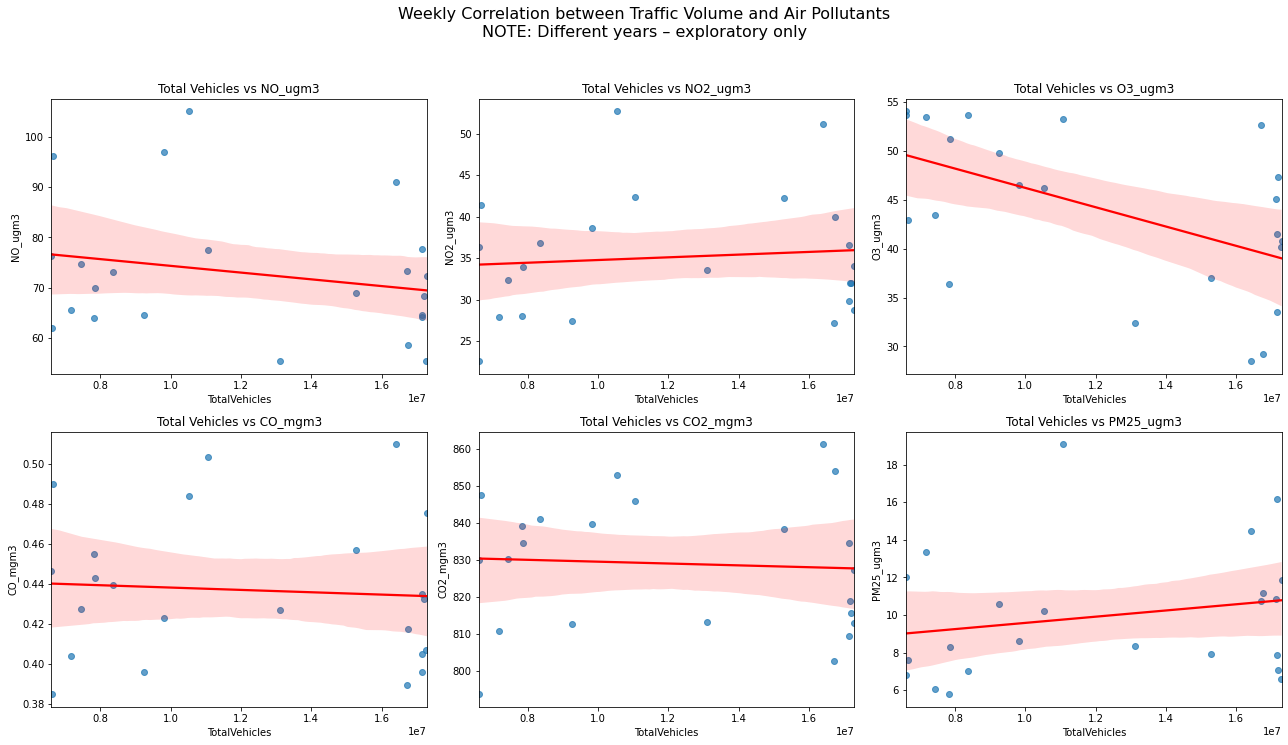

,Week,TotalVehicles,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
Week,1.000000,-0.791746,0.393808,-0.001073,0.575229,0.124587,0.168725,-0.312144
TotalVehicles,-0.791746,1.000000,-0.223842,0.096064,-0.531529,-0.071249,-0.061468,0.214003
NO_ugm3,0.393808,-0.223842,1.000000,0.719246,0.075999,0.612571,0.606762,0.220861
NO2_ugm3,-0.001073,0.096064,0.719246,1.000000,-0.347839,0.796693,0.868288,0.356825
O3_ugm3,0.575229,-0.531529,0.075999,-0.347839,1.000000,-0.251977,-0.407518,-0.012591
CO_mgm3,0.124587,-0.071249,0.612571,0.796693,-0.251977,1.000000,0.797751,0.347098
CO2_mgm3,0.168725,-0.061468,0.606762,0.868288,-0.407518,0.797751,1.000000,0.253380
PM25_ugm3,-0.312144,0.214003,0.220861,0.356825,-0.012591,0.347098,0.253380,1.000000


In [ ]:
# Plot correlation between traffic and each pollutant
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.regplot(
        ax=axes[i],
        data=merged,
        x='TotalVehicles',
        y=pollutant,
        scatter_kws={'alpha': 0.7},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'Total Vehicles vs {pollutant}')

plt.suptitle('Weekly Correlation between Traffic Volume and Air Pollutants\nNOTE: Different years – exploratory only', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

# Show correlation values
merged.corr()


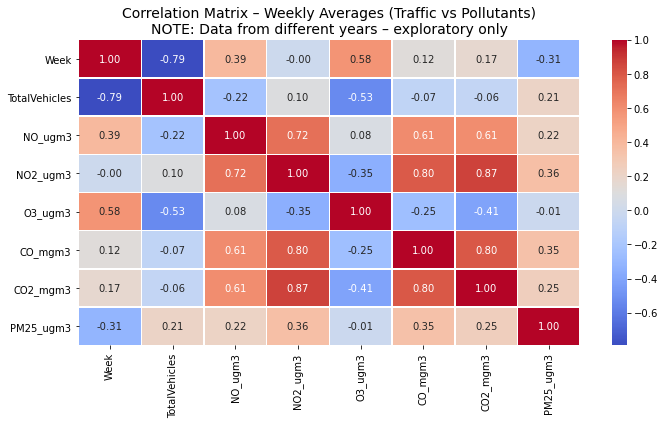

In [ ]:
# Correlation matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix – Weekly Averages (Traffic vs Pollutants)\nNOTE: Data from different years – exploratory only', fontsize=14)
plt.tight_layout()
plt.show()


📊 Interpretation of the Correlation Plots – Hypothesis 1: More Cars = Worse Air Quality
The plots display the weekly correlation between total vehicle volume and the average concentration of each air pollutant.

Each blue dot represents one week of data, combining traffic volumes (from January to June 2020) and air quality measurements (from April to September 2022). The red line indicates the linear trend, and the shaded area represents the confidence interval.

#### 🔍 Pollutant-by-pollutant interpretation:
- NO (Nitric Oxide):
The trend is slightly negative, suggesting that higher traffic volumes are not consistently associated with increased NO levels. This goes against expectations and may reflect data noise or meteorological influences.

- NO₂ (Nitrogen Dioxide):
The trend is almost flat, with a very weak positive slope. NO₂ is typically a key indicator of vehicle emissions, but no strong correlation is observed here.

- O₃ (Ozone):
The plot shows a negative trend. This is expected, as NO reacts with O₃ and tends to reduce its concentration in areas with heavy traffic. This relationship is consistent with real-world chemical behavior.

- CO (Carbon Monoxide):
The trend is nearly flat, indicating no significant correlation with vehicle volume. Weekly CO variations appear to be minor or influenced by other sources.

- CO₂ (Carbon Dioxide):
A very slight negative trend is observed, but with minimal variation. CO₂ is a background gas affected by multiple factors and may not reflect short-term traffic changes.

- PM2.5 (Fine Particulate Matter):
A slightly positive trend appears, which could suggest that traffic contributes to particle emissions. However, the correlation remains weak due to wide dispersion across weeks.



#### 📌 Conclusion:
While some pollutants (such as O₃ and PM2.5) show trends that align with the initial hypothesis (i.e., more cars lead to worse air quality), most relationships are weak or inconsistent.
This may be explained by:

The difference in the year of data collection (2020 for traffic vs. 2022 for air quality);

Meteorological variability and wind dispersion;

The influence of other pollution sources;

Sensor limitations or measurement noise.

These results highlight the importance of using temporally aligned datasets and controlling for external factors when testing environmental hypotheses.



# Hypothesis 2

### Hypothesis 2: Better air quality = more people cycling/walking

In [ ]:
# Load both datasets (adjust paths as needed)
cycle_df = pd.read_csv('../arquivos/cycle-counts-2022.csv', parse_dates=['Time'], dayfirst=True)
pedestrian_df = pd.read_csv('../arquivos/pedestrian-counts-2022.csv', parse_dates=['Time'], dayfirst=True)

# Sum all count columns (excluding Time)
cycle_df['TotalCyclists'] = cycle_df.drop(columns=['Time']).sum(axis=1)
pedestrian_df['TotalPedestrians'] = pedestrian_df.drop(columns=['Time']).sum(axis=1)

# Combine pedestrian and cyclist counts
people_df = pd.DataFrame()
people_df['Time'] = cycle_df['Time']  # assume time columns match
people_df['TotalPeople'] = cycle_df['TotalCyclists'] + pedestrian_df['TotalPedestrians']

# Add ISO week number
people_df['Week'] = people_df['Time'].dt.isocalendar().week

# Weekly average of total people (cycling + walking)
weekly_people = people_df.groupby('Week')['TotalPeople'].mean().reset_index()


Step 2 – Load air quality data and calculate weekly means

In [ ]:
weekly_air = air_weekly

merged = pd.merge(weekly_people, weekly_air, on='Week')
merged

,Week,TotalPeople,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
0,1,58436.553571,55.479452,33.549393,32.419976,0.427138,813.027704,8.352430
1,2,57551.898810,91.039419,51.161224,28.486398,0.509882,861.245436,14.489076
2,3,58636.535714,58.739115,39.996675,29.194741,0.417436,853.884399,11.194371
3,4,60538.797619,77.648664,36.631790,33.561393,0.434940,834.456903,16.152906
4,5,59054.815476,55.422083,28.710196,40.153819,0.407237,812.857911,6.622216
5,6,59055.130952,64.624404,32.009159,41.494506,0.404871,818.680113,7.853277
6,7,57209.339286,64.239496,29.851387,45.086478,0.396332,809.412513,10.871445
7,8,60386.035714,73.351126,27.118116,52.684611,0.389608,802.659280,10.748526
8,9,70091.303571,72.440162,34.007266,40.777553,0.475638,827.240650,11.884064
9,10,67712.636905,68.417519,31.953444,47.292980,0.432691,815.532073,7.103065


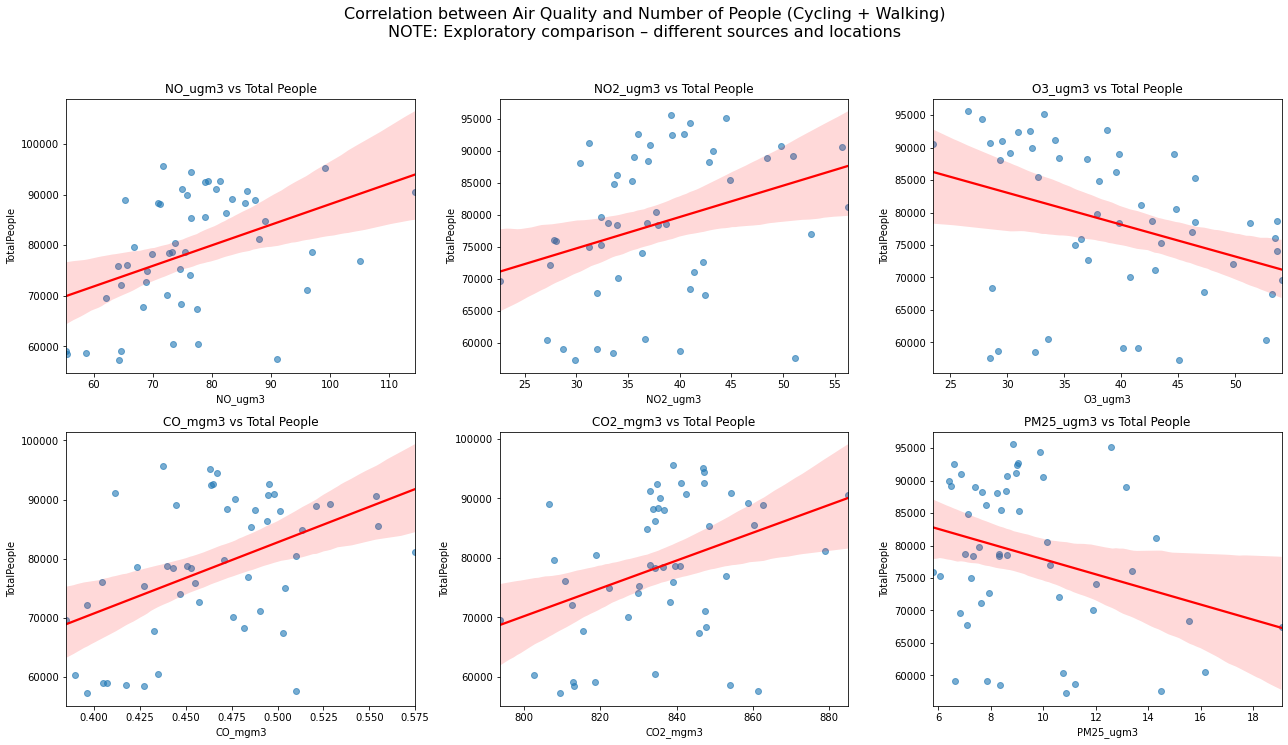

In [ ]:
# Plot scatter plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.regplot(
        ax=axes[i],
        data=merged,
        x=pollutant,
        y='TotalPeople',
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'{pollutant} vs Total People')

plt.suptitle('Correlation between Air Quality and Number of People (Cycling + Walking)\nNOTE: Exploratory comparison – different sources and locations', y=1.03, fontsize=16)
plt.tight_layout()
plt.show()